In [5]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas import DataFrame,Series
import seaborn as sns
from tqdm.notebook import tqdm
import umap
import json
from datetime import datetime

import altair as alt
from sklearn.cluster import AgglomerativeClustering

from src.parsing import read_post_data, replace_single_quotes
from src.paths import *

sns.set_theme(style="whitegrid")
tqdm.pandas()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def get_number(s):
    try:
        return float(s)
    except ValueError:
        return None

In [6]:
posts = read_post_data(datap('posts.csv'))
# posts = posts[posts.tags.map(len) > 0].copy()
posts = posts[posts.userId != '-']

users, comments = [pd.read_csv(datap(f'{n}.csv'), index_col='_id') for n in ['users', 'comments']]
comments = comments[comments.postId.notna()].copy()
users['posts'] = users['posts'].map(lambda x: json.loads(replace_single_quotes(x))).map(lambda x: [v['_id'] for v in x])
comments['score'] = comments['score'].map(get_number)
comments['baseScore'] = comments['baseScore'].map(get_number)

<ipython-input-6-92dce1c872a8>:5: DtypeWarning: Columns (3,5,6,7,9) have mixed types. Specify dtype option on import or set low_memory=False.
  users, comments = [pd.read_csv(datap(f'{n}.csv'), index_col='_id') for n in ['users', 'comments']]


## Segment users

### Extract features

- [X] Number of posts
- [X] Number of comments
- [X] Num. posts per time
- [X] Num. comments per time
- [X] Karma per post (LQ/Mean/UQ)
- [X] Karma per comment (LQ/Mean/UQ)
- [X] Fraction of questions in posts
- [X] Bio filled

In [7]:
from collections import defaultdict
posts_per_user = defaultdict(lambda: [])
for pid,uid,coaths in zip(posts.index, posts.userId, posts.coauthors):
    for u in [uid] + [v['_id'] for v in coaths]:
        posts_per_user[u].append(pid)

posts_per_user = Series(posts_per_user)

In [8]:
users['posts'] = posts_per_user.reindex(users.index).map(lambda x: x if not isinstance(x, float) else [])
users['comments'] = Series(comments.index.groupby(comments.userId)).reindex(users.index).\
    map(lambda x: list(x) if not isinstance(x, float) else [])

In [40]:
# posts_per_user.map(len)[(posts_per_user.map(len) > 2) & (posts_per_user.map(len) < 70)].hist(bins=100)

In [36]:
# users.loc[posts_per_user[posts_per_user.map(len) > 40].index]

In [9]:
user_info = DataFrame(dict(
    karma = users['karma'].fillna(0),
    n_posts = users['posts'].map(len),
    n_comments = users['comments'].map(len),
    lifespan = datetime.now().date() - users['createdAt'].map(lambda x: datetime.strptime(x, '%Y-%m-%dT%H:%M:%S.%fZ').date()),
    category = ''
))

user_info['n_days'] = user_info['lifespan'].map(lambda x: x.days)

for c in ['n_posts', 'n_comments']:
    user_info[c + '_norm'] = user_info[c] / (user_info.n_days / 365)

user_info['question_frac'] = users['posts'].map(lambda ps: None if len(ps) == 0 else posts.question[ps].mean())
user_info['bio_filled'] = users.bio.isna()

In [10]:
user_info[[f'post_score_{k}' for k in ['lq', 'med', 'uq']]] = np.concatenate(users['posts'].map(
    lambda ps: np.atleast_2d(np.array([None, None, None]) if len(ps) == 0 else np.quantile(posts.baseScore[ps].values, [0.25, 0.5, 0.75]))
).values, axis=0)

user_info[[f'comment_score_{k}' for k in ['lq', 'med', 'uq']]] = np.concatenate(users['comments'].map(
    lambda cs: np.atleast_2d(np.array([None, None, None]) if len(cs) == 0 else np.quantile(comments.baseScore[cs].values, [0.25, 0.5, 0.75]))
).values, axis=0)

### Visualize user groups

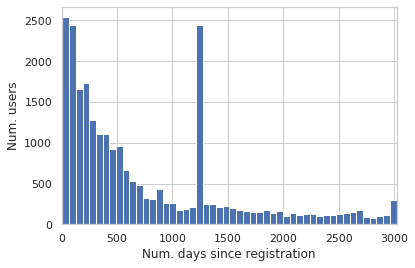

In [11]:
user_info.n_days.hist(bins=50)
plt.xlabel('Num. days since registration'); plt.ylabel('Num. users');
plt.xlim(0, user_info.n_days.max());

In [12]:
user_info.loc[((user_info.n_posts == 0) & (user_info.n_comments == 0)), 'category'] = 'inactive'
user_info.loc[(user_info.n_posts > 70), 'category'] = 'top-writers'

In [13]:
user_info_rest = user_info[user_info.category == '']

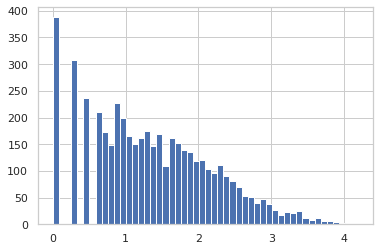

In [14]:
np.log10(user_info_rest.karma[user_info_rest.karma > 0]).hist(bins=50)

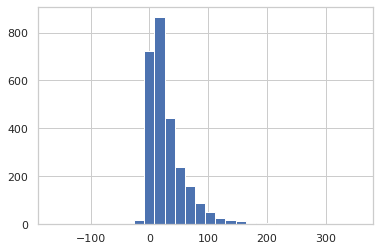

In [15]:
user_info_rest.post_score_med.dropna().hist(bins=30)

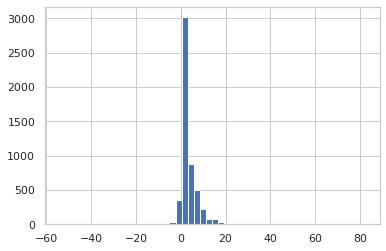

In [16]:
user_info_rest.comment_score_med.hist(bins=50)

## Map users to tags

In [17]:
relevant_posts_per_user = comments.postId.groupby(comments.userId).apply(set)
relevant_posts_per_user = Series(
    [list(set(s1)|set(s2)) for s1,s2 in zip(relevant_posts_per_user, users['posts'][relevant_posts_per_user.index])],
    relevant_posts_per_user.index
)

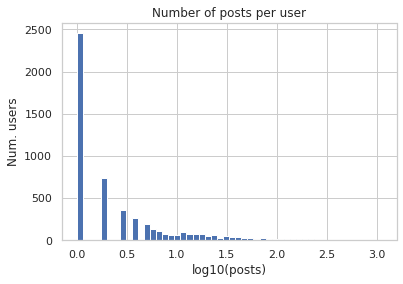

In [18]:
np.log10(relevant_posts_per_user.map(len)).hist(bins=50)
plt.title('Number of posts per user'); plt.xlabel('log10(posts)'); plt.ylabel('Num. users');

In [19]:
tags_per_post = dict(posts.tags)
tags_per_user = relevant_posts_per_user.map(lambda x: Series([tags_per_post.get(p, None) for p in x]).explode().value_counts())
tags_per_user = pd.concat(tags_per_user.values, axis=1).fillna(0).T.set_index(tags_per_user.index)
tags_per_user.shape

(5325, 861)

In [20]:
tags_per_user_filt = tags_per_user.iloc[(tags_per_user > 0).sum(axis=1).values >= 5, (tags_per_user > 0).sum().values > 200]
tags_per_user_filt = tags_per_user_filt[tags_per_user_filt.sum(axis=1) > 50]
tags_per_user_filt.shape

(480, 139)

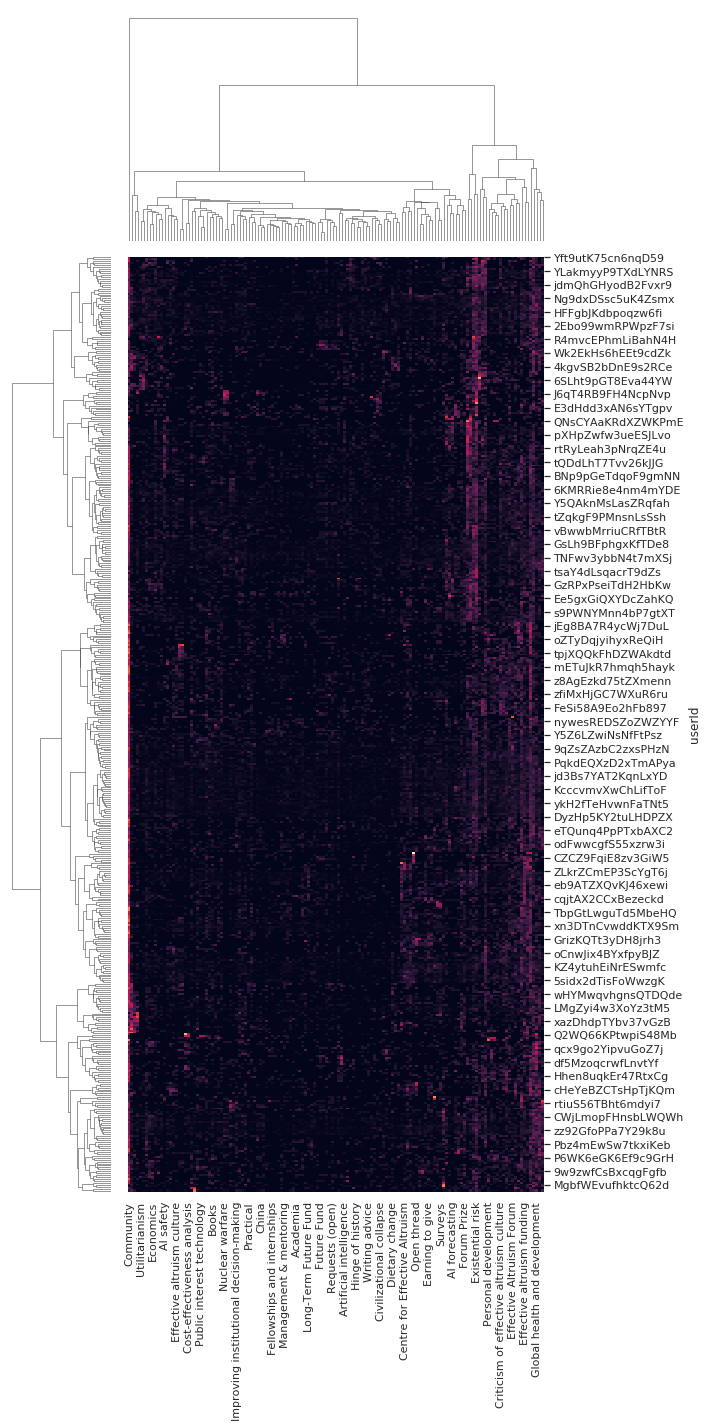

In [21]:
# p_mat = np.log10(tags_per_user_filt + 1)
p_mat = tags_per_user_filt
p_mat = (p_mat.T / p_mat.sum(axis=1)).T
p_mat = np.log10(p_mat * 10 + 1)
sns.clustermap(
    # (tags_per_user_filt > 0),
    # np.log10(tags_per_user_filt / tags_per_user_filt.sum() * 10 + 1),
    p_mat,
    method='ward',
    # method='median',
    # metric='correlation', 
    figsize=(10,20),
    cbar_pos=None
);
plt.tight_layout()

In [22]:
emb = umap.UMAP(metric='cosine', spread=2, min_dist=0.1).fit_transform(p_mat.values)

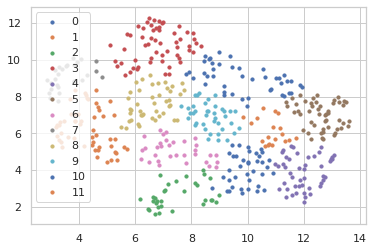

In [23]:
clusts = AgglomerativeClustering(n_clusters=12, affinity='euclidean', linkage='ward').fit_predict(emb)
for c in np.unique(clusts):
    plt.scatter(emb[clusts==c,0], emb[clusts==c,1], label=c, s=10)
plt.legend()

In [24]:
p_mat_agg = p_mat.groupby(clusts).mean().T
score_per_tag = (p_mat_agg > 0.05).mean(axis=1).sort_values(ascending=False)
print("; ".join(score_per_tag.index[score_per_tag > 0.9]))
p_mat_agg = p_mat_agg.loc[score_per_tag.index[score_per_tag < 0.9]]

Criticism of effective altruism; Community; Cause prioritization; Building effective altruism; Career choice


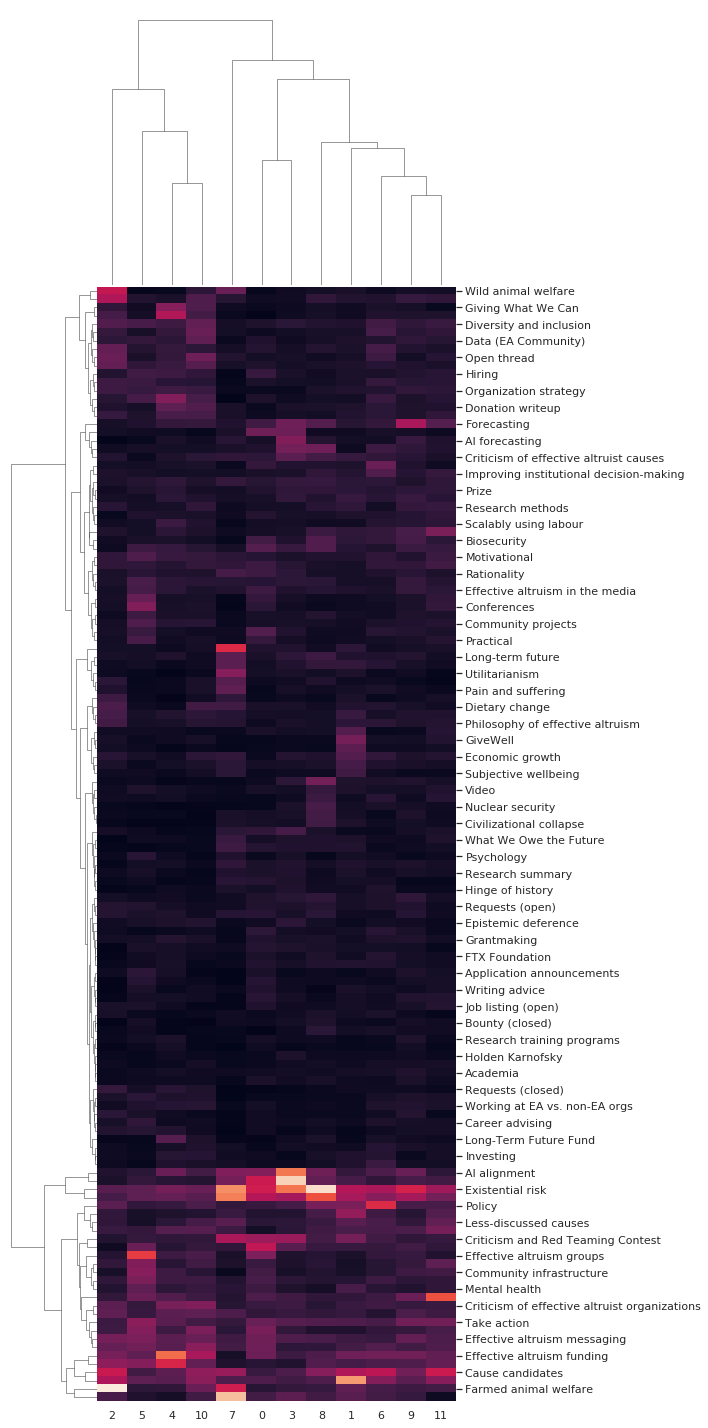

In [25]:
sns.clustermap(
    p_mat_agg / p_mat_agg.sum(),
    method='ward',
    # method='median',
    # metric='correlation', 
    figsize=(10,20),
    cbar_pos=None
);

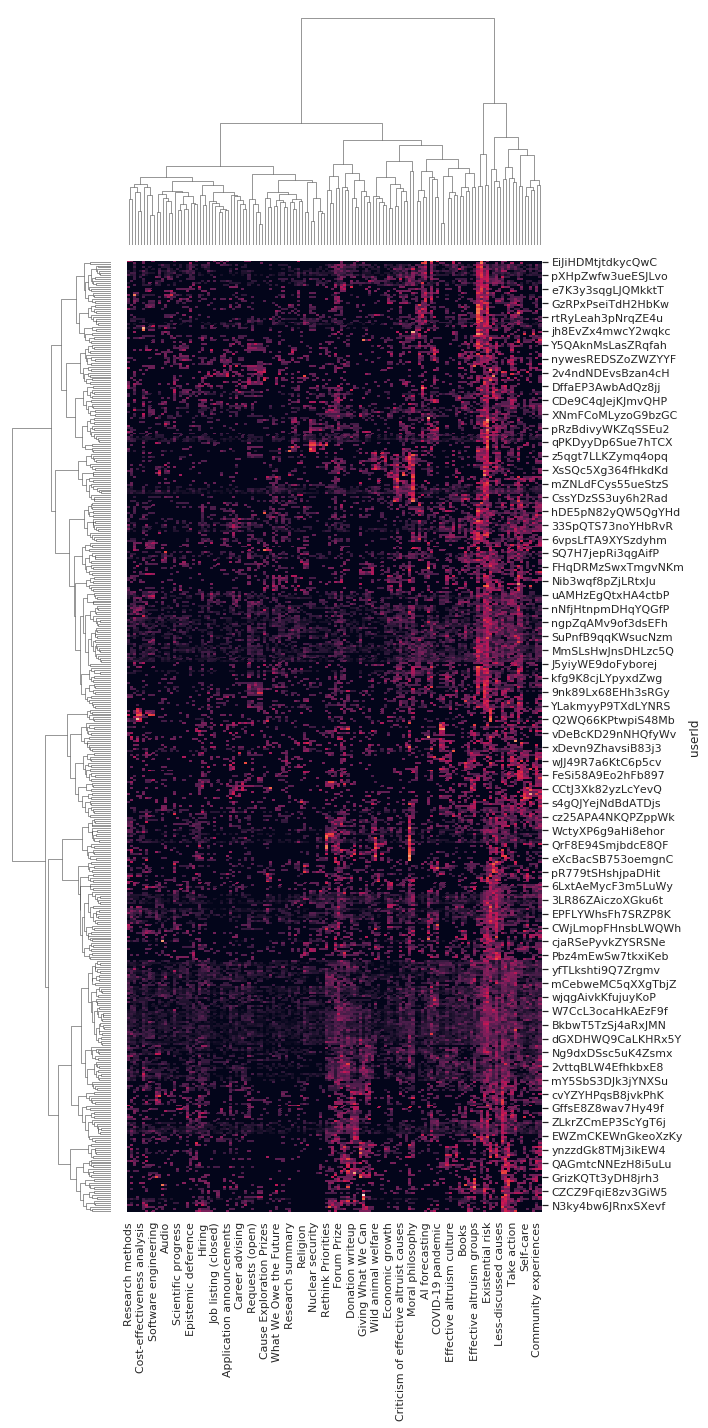

In [26]:
# p_mat = np.log10(tags_per_user_filt + 1)
p_mat2 = tags_per_user_filt.iloc[:, (score_per_tag[tags_per_user_filt.columns] < 0.9).values]
p_mat2 = (p_mat2.T / p_mat2.sum(axis=1)).T
p_mat2 = np.log10(p_mat2 * 100 + 1)
sns.clustermap(
    # (tags_per_user_filt > 0),
    # np.log10(tags_per_user_filt / tags_per_user_filt.sum() * 10 + 1),
    p_mat2,
    method='ward',
    # method='median',
    # metric='correlation', 
    figsize=(10,20),
    cbar_pos=None
);
plt.tight_layout()

### Add vote info

In [27]:
tdf = comments[['postId', 'baseScore', 'userId']].groupby('userId').apply(lambda x: x.baseScore.groupby(x.postId).sum())
tdf = tdf.reset_index(level=1)
tdf['tags'] = tdf['postId'].map(tags_per_post)
tdf = tdf.dropna()

In [28]:
tag_scores_per_user = DataFrame(dict(
    tdf.groupby('userId').apply(
        lambda x: dict(DataFrame([{t: v.baseScore for t in v.tags} for _,v in x.iterrows()]).fillna(0).sum())
    )
)).fillna(0)
tag_scores_per_user = np.maximum(tag_scores_per_user, 0)
tag_scores_per_user = tag_scores_per_user.T[tag_scores_per_user.sum() > 0]

In [29]:
tag_scores_per_user[tag_scores_per_user < 2] = 0
tag_scores_per_user = tag_scores_per_user[tag_scores_per_user.T.sum() > 0]
tag_scores_per_user = tag_scores_per_user.T[tag_scores_per_user.sum() > 0]

In [30]:
p_df = (tag_scores_per_user / tag_scores_per_user.sum()).T
p_df = p_df.iloc[:,(p_df > 0).mean().values > 0.05]
p_df = p_df.iloc[p_df.sum(axis=1).values > 0.01,:]
p_df = np.log10(p_df * 1000 + 1)
p_df.shape

(3913, 106)

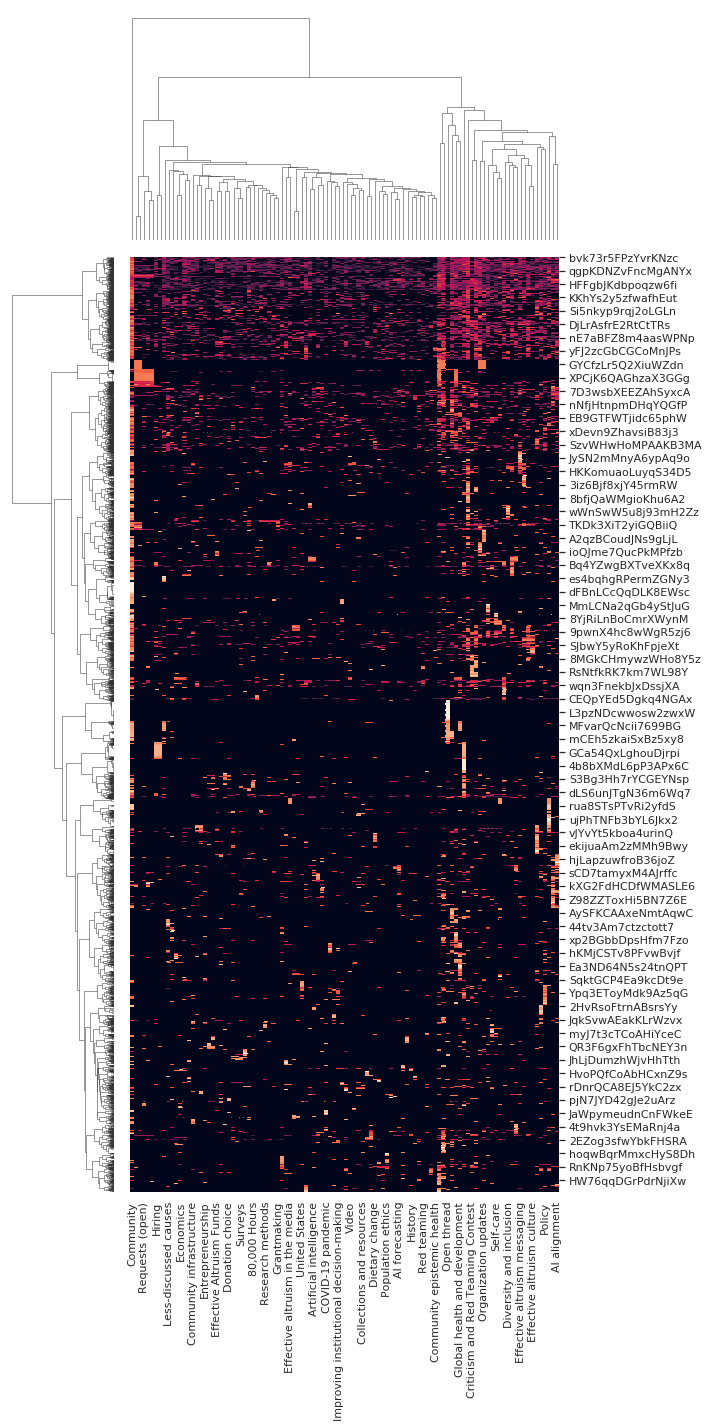

In [31]:
sns.clustermap(
    p_df,
    method='ward',
    # method='median',
    # metric='correlation', 
    figsize=(10,20),
    cbar_pos=None
);
plt.tight_layout()

In [55]:
emb = umap.UMAP(metric='cosine', spread=2, min_dist=0.1).fit_transform(p_df.values)

In [56]:
clusts = AgglomerativeClustering(n_clusters=15, affinity='euclidean', linkage='ward').fit_predict(emb)

adf = DataFrame(emb, index=p_df.index, columns=['x', 'y'])
adf['clust'] = clusts
adf['url'] = users.pageUrl[adf.index]
adf['user'] = users.username[adf.index]

alt.Chart(adf).mark_circle(size=10).encode(
    x='x',
    y='y',
    color='clust:N',
    tooltip=['user', 'url', 'clust']
)

/home/vpetukhov/local/miniconda3/envs/pip/lib/python3.8/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.Chart(...)

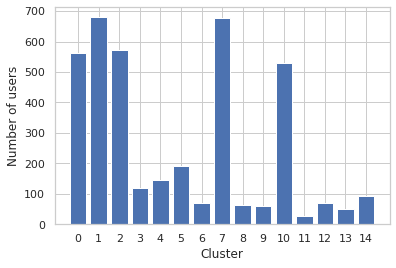

In [57]:
n_users_per_clust = pd.value_counts(clusts).sort_index()
plt.bar(n_users_per_clust.index, n_users_per_clust.values)
plt.xlabel('Cluster'); plt.ylabel('Number of users');
plt.xticks(n_users_per_clust.index);

In [58]:
p_df_agg = p_df.groupby(clusts).mean().T

In [64]:
scores_per_clust = Series({c: r.sort_values(ascending=False)[:10] for c,r in p_df_agg.T.iterrows()})
users_per_clust = users.username[p_df.index].groupby(clusts).apply(list)

scores_per_clust[0]

AI risk                              0.594052
Longtermism                          0.400720
Existential risk                     0.359676
AI alignment                         0.352675
Moral philosophy                     0.326940
Community                            0.248437
Global health and development        0.241975
AI safety                            0.240083
Cause prioritization                 0.191710
Criticism and Red Teaming Contest    0.183642
Name: 0, dtype: float64

In [66]:
users_per_clust[0][:20]

['jablevine',
 'Tony Barrett',
 'davidoj',
 'AstaK',
 'mhendric',
 'Fernando Irarrázaval',
 'DavidRooke',
 'ezrah',
 'fawwaz-anvilen',
 'Samrin Saleem',
 'fergusq',
 'Nick_Robinson',
 'JohnGreer',
 'BrooksHowell',
 'charbel-raphael-segerie',
 'CTownBrooklyn',
 'TruePath',
 'mornemorkel443',
 'anea',
 'Verden']

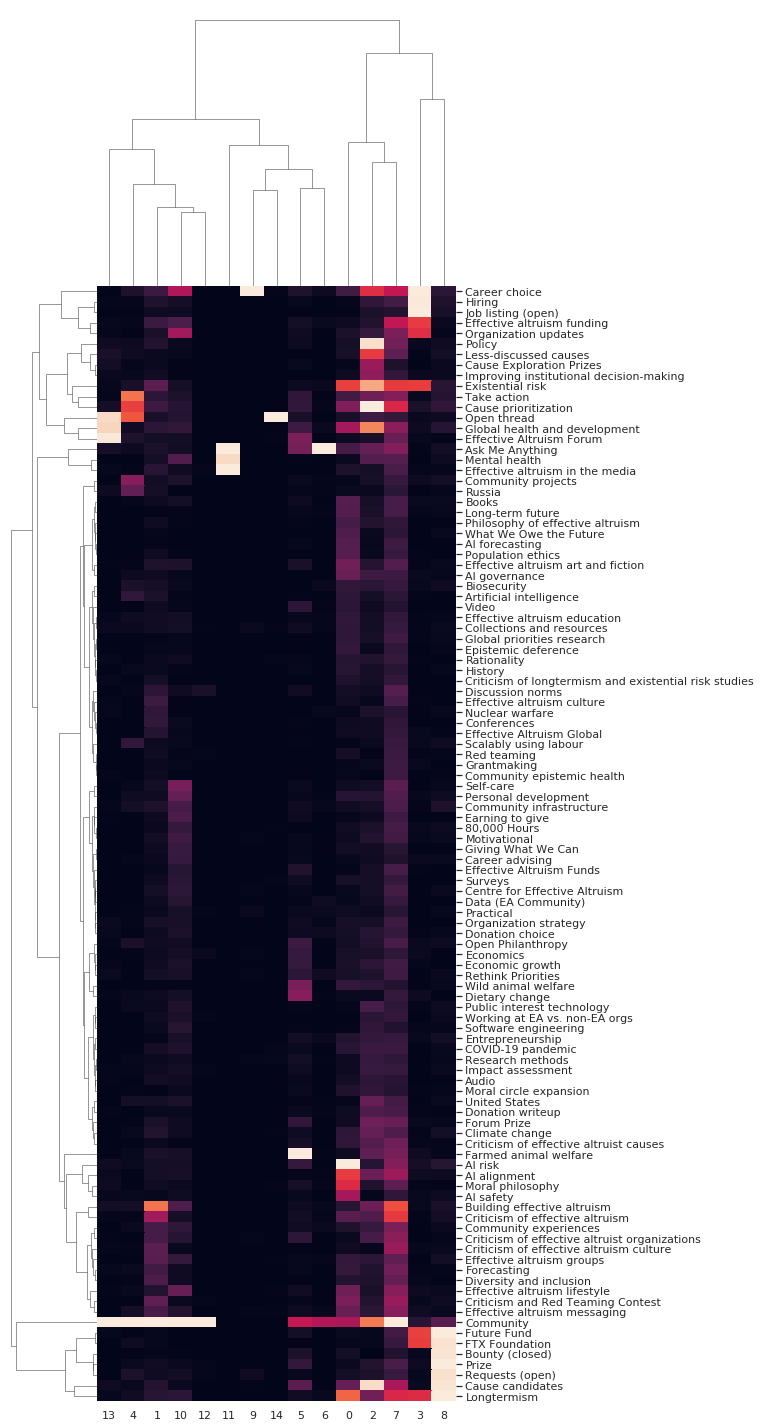

In [61]:
# score_per_tag = (p_mat_agg > 0.05).mean(axis=1).sort_values(ascending=False)
# print("; ".join(score_per_tag.index[score_per_tag > 0.9]))
# p_mat_agg = p_mat_agg.loc[score_per_tag.index[score_per_tag < 0.9]]

cmap = sns.clustermap(
    p_df_agg / p_df_agg.max(),
    method='ward',
    # method='median',
    # metric='correlation', 
    figsize=(10,20),
    cbar_pos=None
);

cmap.ax_heatmap.set_yticks(np.arange(p_df_agg.index.size) + 0.5);
cmap.ax_heatmap.set_yticklabels(p_df_agg.index[cmap.dendrogram_row.reordered_ind], rotation=0);

In [453]:
p_df.loc[adf.index[adf.user == 'Lauren Reid'][0]].sort_values(ascending=False)[:20]

FTX Foundation                  2.057514
Cause candidates                2.051089
Future Fund                     2.041270
Bounty (closed)                 2.041270
Longtermism                     2.041270
Requests (open)                 2.041270
Prize                           2.041270
Take action                     1.341545
Community                       1.307049
Mental health                   1.075434
Career choice                   1.043703
Self-care                       1.043703
Less-discussed causes           1.043703
Cause prioritization            1.043703
Effective altruism lifestyle    1.043703
Job listing (open)              1.009470
Rethink Priorities              1.009470
Building effective altruism     1.009470
Entrepreneurship                0.931662
Public interest technology      0.931662
Name: xRqi8hGJv6hZZweRM, dtype: float64

In [454]:
p_df.loc[adf.index[adf.user == 'Leo Gao'][0]].sort_values(ascending=False)[:20]

Bounty (closed)                            2.181380
Prize                                      2.181380
Cause candidates                           2.139475
Future Fund                                2.139475
FTX Foundation                             2.139475
Longtermism                                2.139475
Requests (open)                            2.139475
AI risk                                    1.175120
Donation writeup                           0.000000
Effective altruism culture                 0.000000
Rethink Priorities                         0.000000
Public interest technology                 0.000000
History                                    0.000000
AI governance                              0.000000
Criticism of effective altruism culture    0.000000
Moral philosophy                           0.000000
Research methods                           0.000000
Donation choice                            0.000000
Effective altruism groups                  0.000000
Effective al

### Map users to tags

In [ ]:
# relevant_posts_per_user = comments.postId.groupby(comments.userId).apply(set)
# relevant_posts_per_user = Series(
#     [list(set(s1)|set(s2)) for s1,s2 in zip(relevant_posts_per_user, users['posts'][relevant_posts_per_user.index])],
#     relevant_posts_per_user.index
# )